In [1]:
import torch
import torchvision.datasets
import random
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [4]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [0]:
X_train /= 255.
X_test /= 255.

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

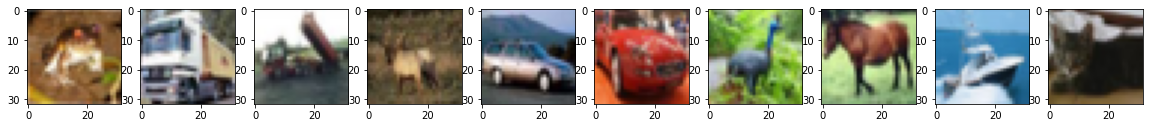

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [0]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [0]:
# СЕТИ
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)

        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1  = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)

        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4  = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        
        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        
        self.fc3   = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.fc3(x)
        
        return x

# RESNET
from torchvision.models import resnet18
from torchvision.models import resnet34
from torchvision.models import resnet101

In [0]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(10):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)
    del net
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}

In [10]:
accuracies['cifar_net'], losses['cifar_net'] = \
    train(CIFARNet(), X_train, y_train, X_test, y_test)
accuracies['resnet18'], losses['resnet18'] = \
    train(resnet18(), X_train, y_train, X_test, y_test)
accuracies['resnet34'], losses['resnet34'] = \
    train(resnet34(), X_train, y_train, X_test, y_test)
accuracies['resnet101'], losses['resnet101'] = \
    train(resnet101(), X_train, y_train, X_test, y_test)

tensor(0.6619)
tensor(0.6966)
tensor(0.7063)
tensor(0.7038)
tensor(0.7137)
tensor(0.7146)
tensor(0.7136)
tensor(0.7035)
tensor(0.7107)
tensor(0.7076)
tensor(0.4970)
tensor(0.6525)
tensor(0.6814)
tensor(0.7098)
tensor(0.6803)
tensor(0.7183)
tensor(0.7255)
tensor(0.6963)
tensor(0.7159)
tensor(0.7400)
tensor(0.4444)
tensor(0.5899)
tensor(0.4210)
tensor(0.6617)
tensor(0.7377)
tensor(0.7096)
tensor(0.6952)
tensor(0.7258)
tensor(0.7414)
tensor(0.7487)


RuntimeError: ignored

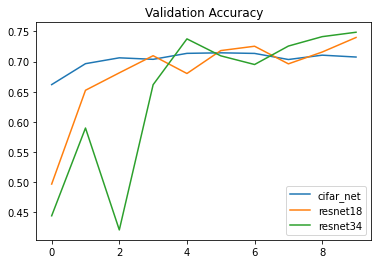

In [11]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

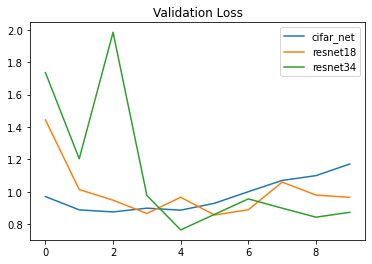

In [12]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');